In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import sklearn.linear_model
import os.path

import time

from NeuralNet import NeuralNet
from utils.json import read_from_json
from utils.nnsetup import get_datasets
from attacks.attacks import Attack

np.random.seed(1)

In [2]:
X_train, Y_train, Y_train_e, X_test, Y_test = get_datasets()

In [3]:
cls = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300, \
                         normalize = False, mini_batch_size=2048)

cls.parameters = read_from_json("nets/main_nn_300")

In [4]:
cls_dist = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300, \
                         normalize = False, mini_batch_size=2048)

cls_dist.parameters = read_from_json("nets/distilled_nn_300")

In [5]:
def L2_norm(x, axis=0):
  return np.sqrt(np.square(x).sum(axis=axis))

In [6]:
attack_raw = Attack(cls)

df = pd.DataFrame(columns = ['target','successful attempts', 'epsilon']) #'initial',
non_targeted = pd.DataFrame(columns = ['original','prediction','iterations', 'epsilon', 'L2 norm'])

X_test_c = X_test[:300].copy()
Y_test_c = Y_test[:300].copy()

Y_hat_c = cls.predict(X_test_c)


tick = time.time()
for epsilon in [1/255]:#, 3/255, 5/255, 10/255, 15/255, 30/255, 50/255, 80/255, 120/255]:#[1/255]:#0.007, 0.01, 0.05, 0.1, 0.2]:
    print('epsilon =',epsilon)
    total_attempts = 0
    total_iter = 0
    example = []
    initial = []
    true_label = []
    adversarial = []
    y_hat_adv = []
    for (x, y, y_hat) in zip(X_test_c, Y_test_c, Y_hat_c):
        x = np.array([x])
        prediction = y_hat

        if(y == y_hat):

            x_adv = attack_raw.attack(x,\
                                      np.array([[1 if i==y else 0 for i in range(10)]]),\
                                      #'ADAM',\
                                      'FGSM',\
                                      #'grads',\
                                      10000,\
                                      #pretrub_importance=0.01,\
                                      adapting_rate=epsilon, print_cost=False, targeted=False).T[0]
            
            total_iter += attack_raw.iter

            example.append(x_adv)
            true_label.append([y])

            total_attempts += 1
            prediction = cls.predict(np.array([x_adv]))[0]
            if(prediction != y):
                initial.append(x[0])
                adversarial.append(x_adv)
                
                non_targeted = non_targeted.append({'original': y[0],'prediction': prediction,\
                                 'iterations': attack_raw.iter, 'L2 norm': L2_norm(x[0]-x_adv),\
                                 'epsilon': epsilon}, ignore_index=True)
                
        y_hat_adv.append(prediction)
        
        if(total_attempts% 10 == 0): print(total_attempts,'instances,', len(adversarial), 'adversaries');

    example = np.array(example)
    initial = np.array(initial)
    true_label = np.array(true_label)
    adversarial = np.array(adversarial)
    y_hat_adv = np.array(y_hat_adv)

    print('------------------------------',example.shape)
    Y_hat = cls.predict(example).reshape(true_label.shape)

    #print((Y_hat == target).shape)
    #print((Y_hat != Y_test) * (Y_hat == target) * ((cls.predict(X_test)==Y_test).reshape(Y_hat.shape)))

    successful_attempts = len(adversarial)#np.sum(
    #  (Y_hat != true_label)
    #  * (Y_hat == target))
      #* (true_label == cls.predict(X_test_c).reshape(true_label.shape)))

    df = df.append({'successful attempts': successful_attempts, 'epsilon': epsilon}, ignore_index=True)

print('total time:', time.time() - tick)
print('total iter:', total_iter)
df

epsilon = 0.00392156862745098
10 instances, 10 adversaries
20 instances, 20 adversaries
30 instances, 30 adversaries
30 instances, 30 adversaries
40 instances, 40 adversaries
50 instances, 50 adversaries
60 instances, 60 adversaries
70 instances, 70 adversaries
80 instances, 80 adversaries
90 instances, 90 adversaries
100 instances, 100 adversaries
110 instances, 110 adversaries
120 instances, 120 adversaries
130 instances, 130 adversaries
140 instances, 140 adversaries
150 instances, 150 adversaries
160 instances, 160 adversaries
170 instances, 170 adversaries
180 instances, 180 adversaries
190 instances, 190 adversaries
200 instances, 200 adversaries
210 instances, 210 adversaries
220 instances, 220 adversaries
230 instances, 230 adversaries
240 instances, 240 adversaries
250 instances, 250 adversaries
260 instances, 260 adversaries
270 instances, 270 adversaries
280 instances, 280 adversaries
290 instances, 290 adversaries
------------------------------ (293, 784)
total time: 9.2474

,target,successful attempts,epsilon
0,NaN,293.0,0.003922


In [7]:
non_targeted.head()

,original,prediction,iterations,epsilon,L2 norm
0,7.0,3.0,20.0,0.003922,1.647185
1,3.0,5.0,30.0,0.003922,2.385987
2,9.0,4.0,3.0,0.003922,0.245372
3,8.0,2.0,12.0,0.003922,1.027092
4,6.0,2.0,17.0,0.003922,1.482369


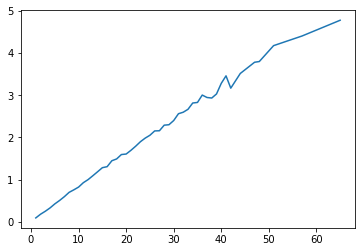

In [8]:
pretrub_by_iter = non_targeted.groupby('iterations', as_index=False)['L2 norm'].mean()
pretrub_by_iter = pretrub_by_iter.sort_values("iterations")

plt.plot(pretrub_by_iter['iterations'], pretrub_by_iter['L2 norm'])

In [9]:
accuracy_t = []
for iter in pretrub_by_iter["iterations"].values:
    accuracy_t.append(1 - non_targeted[non_targeted["iterations"]<=iter].shape[0]/total_attempts)
    
iterations_t = pretrub_by_iter["iterations"].values

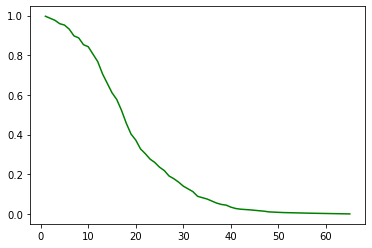

In [10]:
FGSM_t, = plt.plot(iterations_t, accuracy_t, 'g-', label='TFGSM')

In [21]:
attack_dist = Attack(cls_dist)

df = pd.DataFrame(columns = ['target','successful attempts', 'epsilon']) #'initial',
non_targeted_dist = pd.DataFrame(columns = ['original','prediction','iterations', 'epsilon', 'L2 norm'])

X_test_c = X_test[:300].copy()
Y_test_c = Y_test[:300].copy()

Y_hat_c = cls.predict(X_test_c)


tick = time.time()
for epsilon in [1/255]:#, 3/255, 5/255, 10/255, 15/255, 30/255, 50/255, 80/255, 120/255]:#[1/255]:#0.007, 0.01, 0.05, 0.1, 0.2]:
    print('epsilon =',epsilon)
    total_attempts = 0
    total_iter = 0
    example = []
    initial = []
    true_label = []
    adversarial = []
    y_hat_adv = []
    for (x, y, y_hat) in zip(X_test_c, Y_test_c, Y_hat_c):
        x = np.array([x])
        prediction = y_hat

        if(y == y_hat):

            x_adv = attack_dist.attack(x,\
                                      np.array([[1 if i==y else 0 for i in range(10)]]),\
                                      #'ADAM',\
                                      'FGSM',\
                                      #'grads',\
                                      10000,\
                                      #pretrub_importance=0.01,\
                                      adapting_rate=epsilon, print_cost=False, targeted=False).T[0]
            
            total_iter += attack_dist.iter

            example.append(x_adv)
            true_label.append([y])

            total_attempts += 1
            prediction = cls.predict(np.array([x_adv]))[0]
            if(prediction != y):
                initial.append(x[0])
                adversarial.append(x_adv)
                
                non_targeted_dist = non_targeted_dist.append({'original': y[0],'prediction': prediction,\
                                 'iterations': attack_dist.iter, 'L2 norm': L2_norm(x[0]-x_adv),\
                                 'epsilon': epsilon}, ignore_index=True)
                
        y_hat_adv.append(prediction)
        
        if(total_attempts% 10 == 0): print(total_attempts,'instances,', len(adversarial), 'adversaries');

    example = np.array(example)
    initial = np.array(initial)
    true_label = np.array(true_label)
    adversarial = np.array(adversarial)
    y_hat_adv = np.array(y_hat_adv)

    print('------------------------------',example.shape)
    Y_hat = cls.predict(example).reshape(true_label.shape)

    #print((Y_hat == target).shape)
    #print((Y_hat != Y_test) * (Y_hat == target) * ((cls.predict(X_test)==Y_test).reshape(Y_hat.shape)))

    successful_attempts = len(adversarial)#np.sum(
    #  (Y_hat != true_label)
    #  * (Y_hat == target))
      #* (true_label == cls.predict(X_test_c).reshape(true_label.shape)))

    df = df.append({'successful attempts': successful_attempts, 'epsilon': epsilon}, ignore_index=True)

print('total time:', time.time() - tick)
print('total iter:', total_iter)
df

epsilon = 0.00392156862745098
------------------------------ (9, 784)
total time: 0.26659655570983887
total iter: 167


,target,successful attempts,epsilon
0,NaN,8.0,0.003922


In [31]:
x_adv = attack_dist.attack(X_test[9:10],\
                                      np.array([[1 if i==y else 0 for i in range(10)]]),\
                                      #'ADAM',\
                                      'FGSM',\
                                      #'grads',\
                                      10000,\
                                      #pretrub_importance=0.01,\
                                      adapting_rate=epsilon, print_cost=False, targeted=False).T[0]

In [32]:
attack_dist.iter

0

In [33]:
x_adv.shape

(784,)

In [34]:
cls_dist.predict(X_test[8:9])

array([4], dtype=int64)

In [35]:
cls_dist.predict(np.array([x_adv.T]))

array([6], dtype=int64)

In [18]:
cls_dist.predict(initial) == cls_dist.predict(adversarial)

array([False, False, False, False, False, False, False, False, False])

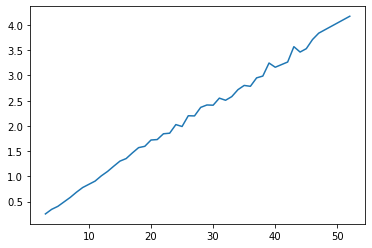

In [12]:
pretrub_by_iter = non_targeted_dist.groupby('iterations', as_index=False)['L2 norm'].mean()
pretrub_by_iter = pretrub_by_iter.sort_values("iterations")

plt.plot(pretrub_by_iter['iterations'], pretrub_by_iter['L2 norm'])

In [13]:
accuracy_t_dist = []
for iter in pretrub_by_iter["iterations"].values:
    accuracy_t_dist.append(1 - non_targeted_dist[non_targeted_dist["iterations"]<=iter].shape[0]/total_attempts)
    
iterations_t_dist = pretrub_by_iter["iterations"].values

In [38]:
iter

52.0

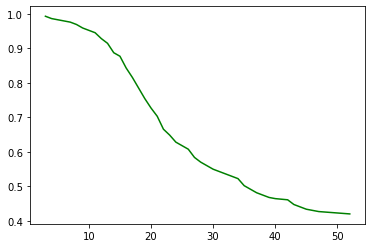

In [14]:
FGSM_t, = plt.plot(iterations_t_dist, accuracy_t_dist, 'g-', label='TFGSM')

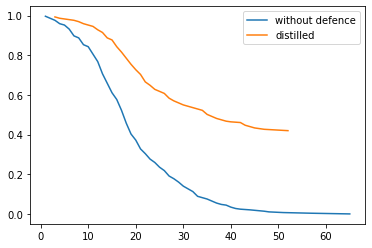

In [15]:
plt.plot(iterations_t, accuracy_t, label='without defence')
plt.plot(iterations_t_dist, accuracy_t_dist, label='distilled')
plt.legend()
plt.show()

Something wrong. Probably algorithm stop condition is uncorrect. Also will be nice to extract samples with initially incorrect classification.

In [36]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.9714583333333333
0.9571428571428572


In [37]:
Y_train_hat = cls_dist.predict(X_train)
Y_test_hat = cls_dist.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.9462202380952381
0.9396428571428571
